# IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

In [3]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils

# Config

In [4]:
# Constants
data_dir = '/kaggle/input/data-resume/Dataset_Resume'
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Data Augmentation

In [5]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# LOAD DATA

In [6]:
# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

In [7]:
# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# SAMPLE DATA
The dataset consists of about 900-1000 files each for resume and non resume categories in jpg format that I myself has collected from kaggle and other useful sources.

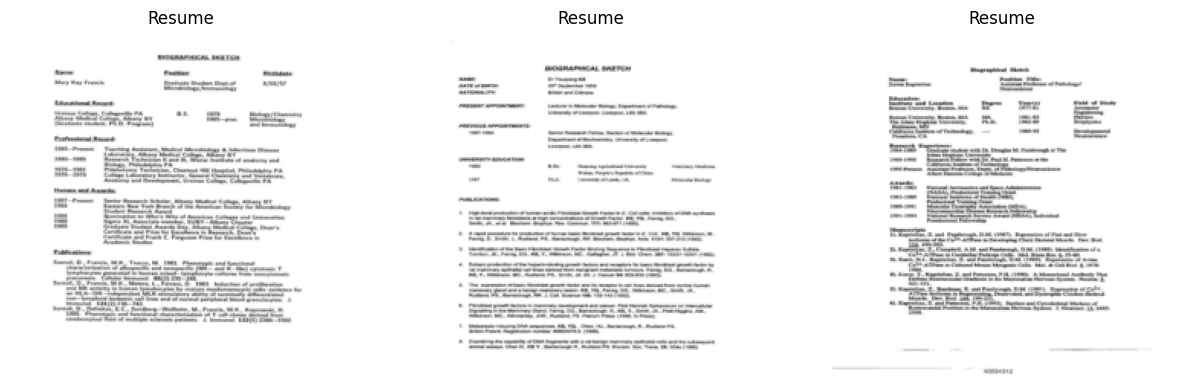

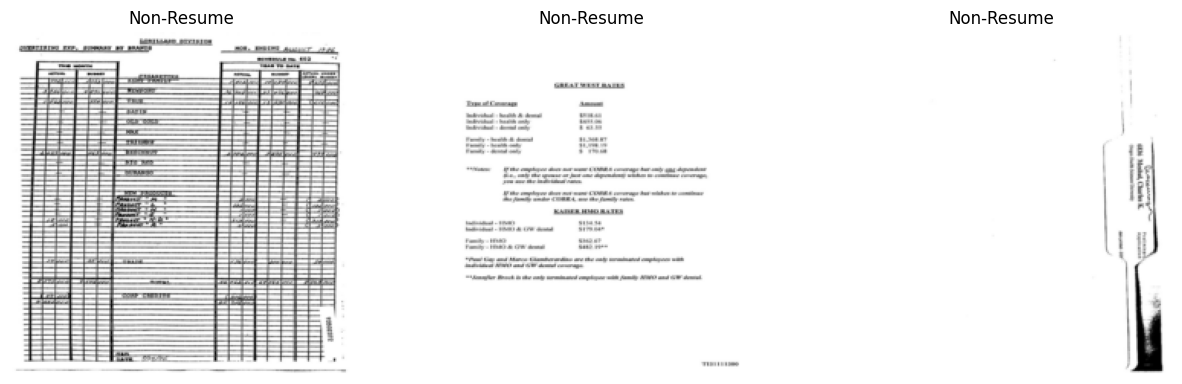

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Assuming that 'resume' class is labeled as 0 and 'non-resume' class is labeled as 1
resume_class = 1
non_resume_class = 0

# Function to display images
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        axs[i].imshow(F.to_pil_image(image))
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# Extract a few samples from the data loader
num_samples = 3
resume_samples = []
non_resume_samples = []

for data, labels in train_loader:
    for image, label in zip(data, labels):
        if label == resume_class and len(resume_samples) < num_samples:
            resume_samples.append(image)
        elif label == non_resume_class and len(non_resume_samples) < num_samples:
            non_resume_samples.append(image)
        
        if len(resume_samples) == num_samples and len(non_resume_samples) == num_samples:
            break
    
    if len(resume_samples) == num_samples and len(non_resume_samples) == num_samples:
        break

# Display the sampled images
show_images(resume_samples, titles=['Resume'] * num_samples)
show_images(non_resume_samples, titles=['Non-Resume'] * num_samples)


# MODEL
This is a Convolutional Neural Network (CNN) architecture for image classification. It consists of three convolutional layers (each followed by max-pooling) to extract hierarchical features, followed by two fully connected layers for classification. The input size is 3 channels (e.g., RGB), and the final output is a 2-class prediction.

In [27]:
# Define the CNN model
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # Adjusted based on the output size from conv3
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x), inplace=True))
        x = self.pool(F.relu(self.conv2(x), inplace=True))
        x = self.pool(F.relu(self.conv3(x), inplace=True))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x), inplace=True)
        x = self.fc2(x)
        return x


In [28]:
# Initialize the model, loss function, and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# METRICS

In [29]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# TRAINING

In [30]:
# Lists to store metrics for each epoch
epochs_list = []
train_accuracy_list = []
precision_list = []
recall_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct = 0
    total_samples = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total_samples += labels.size(0)
        total_correct += predicted.eq(labels).sum().item()

        # Calculate true positive, true negative, false positive, false negative
        true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        true_negative += ((predicted == 0) & (labels == 0)).sum().item()
        false_positive += ((predicted == 1) & (labels == 0)).sum().item()
        false_negative += ((predicted == 0) & (labels == 1)).sum().item()

    train_accuracy = total_correct / total_samples
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

    # Append metrics to lists
    epochs_list.append(epoch + 1)
    train_accuracy_list.append(train_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

    # Print training statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    # You can print other metrics as well, like confusion matrix
    cm = confusion_matrix(labels.numpy(), predicted.numpy())
    print(f'Confusion Matrix:\n{cm}')

Epoch [1/10], Train Accuracy: 0.6035, Precision: 0.5862, Recall: 0.7226
Confusion Matrix:
[[11  1]
 [ 2 14]]
Epoch [2/10], Train Accuracy: 0.7916, Precision: 0.7801, Recall: 0.8160
Confusion Matrix:
[[14  2]
 [ 5  7]]
Epoch [3/10], Train Accuracy: 0.8113, Precision: 0.7992, Recall: 0.8349
Confusion Matrix:
[[ 7  5]
 [ 1 15]]
Epoch [4/10], Train Accuracy: 0.8338, Precision: 0.8252, Recall: 0.8498
Confusion Matrix:
[[ 8  0]
 [ 6 14]]
Epoch [5/10], Train Accuracy: 0.8638, Precision: 0.8617, Recall: 0.8687
Confusion Matrix:
[[10  3]
 [ 1 14]]
Epoch [6/10], Train Accuracy: 0.8774, Precision: 0.8625, Recall: 0.8999
Confusion Matrix:
[[14  1]
 [ 1 12]]
Epoch [7/10], Train Accuracy: 0.9074, Precision: 0.8983, Recall: 0.9202
Confusion Matrix:
[[15  3]
 [ 2  8]]
Epoch [8/10], Train Accuracy: 0.9217, Precision: 0.9194, Recall: 0.9256
Confusion Matrix:
[[11  1]
 [ 3 13]]
Epoch [9/10], Train Accuracy: 0.9353, Precision: 0.9259, Recall: 0.9472
Confusion Matrix:
[[15  0]
 [ 1 12]]
Epoch [10/10], Trai

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# CONFUSION MATRIX

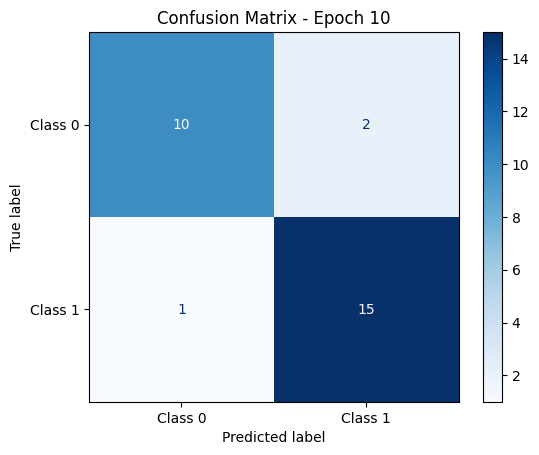

In [32]:
# Plot confusion matrix
cm = confusion_matrix(labels.numpy(), predicted.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
plt.show()

# TESTING

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)

# Assuming you have a DataLoader named 'test_loader' and a model named 'model' already defined

model.eval()  # Set the model to evaluation mode
total_correct_test = 0
total_samples_test = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        total_samples_test += test_labels.size(0)
        total_correct_test += test_predicted.eq(test_labels).sum().item()
        all_predictions.extend(test_predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

# Print confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print(f'Confusion Matrix:\n{cm}')


Test Accuracy: 0.8832
Precision: 0.8419, Recall: 0.9526, F1-Score: 0.8938
Confusion Matrix:
[[144  34]
 [  9 181]]


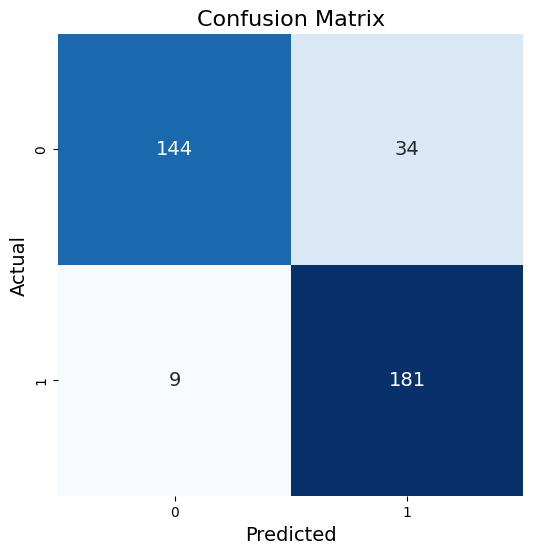

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       178
           1       0.84      0.95      0.89       190

    accuracy                           0.88       368
   macro avg       0.89      0.88      0.88       368
weighted avg       0.89      0.88      0.88       368



In [34]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Display classification report
print(classification_report(all_labels, all_predictions))

# PLOT
The plot shows the variation of accuracy, precision and recall with the number of epochs

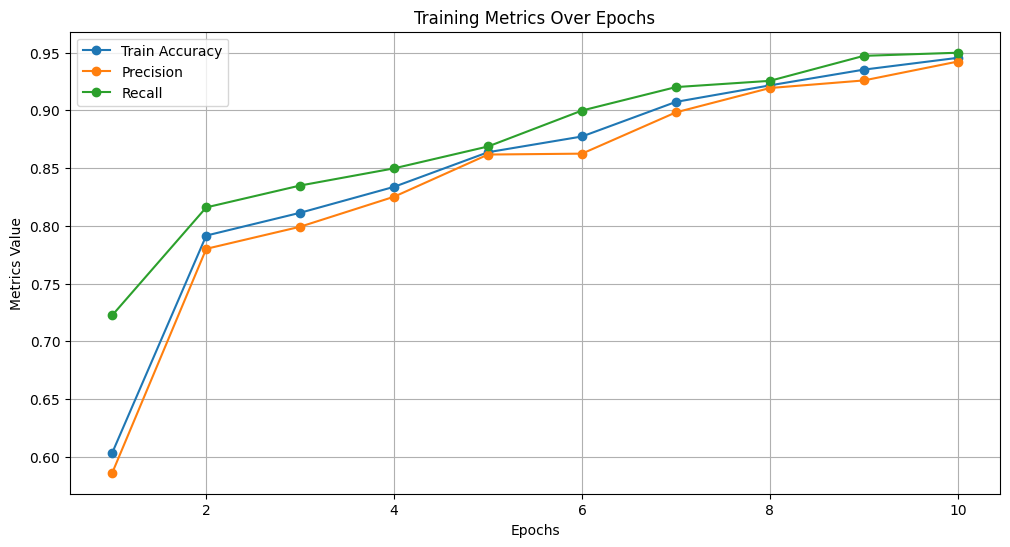

In [35]:
# Plotting
plt.figure(figsize=(12, 6))

plt.plot(epochs_list, train_accuracy_list, label='Train Accuracy', marker='o')
plt.plot(epochs_list, precision_list, label='Precision', marker='o')
plt.plot(epochs_list, recall_list, label='Recall', marker='o')

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend()
plt.grid(True)
plt.show()